In [2]:
# https://skymind.ai/wiki/generative-adversarial-network-gan
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.optimizers.legacy import Adam
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.models import Model

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=32, save_interval=200) #epoch 30,000

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

GAN Class modefied with convolution layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                         

FileNotFoundError: ignored

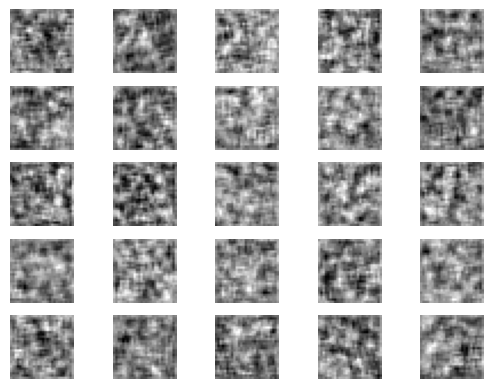

In [3]:
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, Dropout, ZeroPadding2D

class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/mnist-images/mnist_%d.png" % epoch)
        plt.close()

if __name__ == '__main__':
    gan = DCGAN()
    gan.train(epochs=1000, batch_size=32, save_interval=200) #epoch 30,000


GAN Class with convolutional layers for CIFAR10 Dataset

Streaming output truncated to the last 5000 lines.
511 [D loss: 0.681143, acc.: 65.62%] [G loss: 0.718827]
1/1 [==============================] - 0s 61ms/step
512 [D loss: 0.668216, acc.: 71.88%] [G loss: 0.714500]
1/1 [==============================] - 0s 63ms/step
513 [D loss: 0.671117, acc.: 65.62%] [G loss: 0.727502]
1/1 [==============================] - 0s 68ms/step
514 [D loss: 0.664457, acc.: 78.12%] [G loss: 0.716135]
1/1 [==============================] - 0s 64ms/step
515 [D loss: 0.685156, acc.: 46.88%] [G loss: 0.695215]
1/1 [==============================] - 0s 69ms/step
516 [D loss: 0.698748, acc.: 50.00%] [G loss: 0.689237]
1/1 [==============================] - 0s 63ms/step
517 [D loss: 0.689570, acc.: 50.00%] [G loss: 0.663372]
1/1 [==============================] - 0s 64ms/step
518 [D loss: 0.681460, acc.: 53.12%] [G loss: 0.664273]
1/1 [==============================] - 0s 62ms/step
519 [D loss: 0.723840, acc.: 31.25%] [G loss: 0.633177]
1/1 [========================

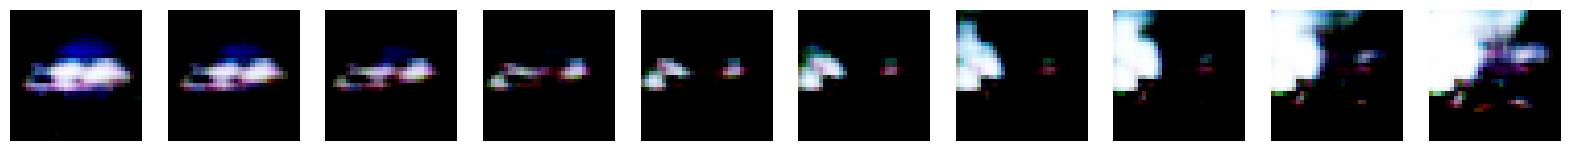

1/1 [==============================] - 0s 17ms/step


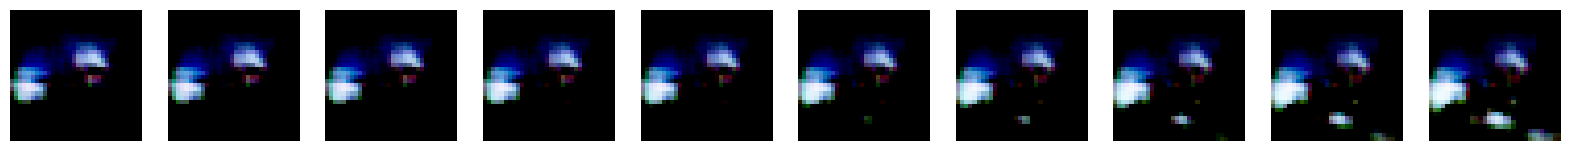

In [5]:
from keras.datasets import cifar10

class DCGAN_CIFAR():
  def __init__(self):
    self.img_rows = 32
    self.img_cols = 32
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                                optimizer=optimizer,
                                metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates imgs
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = self.discriminator(img)

    # The combined model (stacked generator and discriminator)
    self.combined = Model(z, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):

    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
    model.add(Reshape((8, 8, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)

  def build_discriminator(self):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=self.img_shape)
    validity = model(img)

    return Model(img, validity)

  def train(self, epochs, batch_size=128, save_interval=50):

      # Load CIFAR-10 data
      (X_train, y_train), (_, _) = cifar10.load_data()
      # Filter out 'airplane' class which corresponds to label 0
      X_train = X_train[y_train.flatten() == 0]

      # Rescale -1 to 1
      X_train = (X_train.astype(np.float32) - 127.5) / 127.5

      half_batch = int(batch_size / 2)

      for epoch in range(epochs):

          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Select a random half batch of images
          idx = np.random.randint(0, X_train.shape[0], half_batch)
          imgs = X_train[idx]

          noise = np.random.normal(0, 1, (half_batch, 100))

          # Generate a half batch of new images
          gen_imgs = self.generator.predict(noise)

          # Train the discriminator
          d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
          d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


          # ---------------------
          #  Train Generator
          # ---------------------

          noise = np.random.normal(0, 1, (batch_size, 100))

          # The generator wants the discriminator to label the generated samples
          # as valid (ones)
          valid_y = np.array([1] * batch_size)

          # Train the generator
          g_loss = self.combined.train_on_batch(noise, valid_y)

          # Plot the progress
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

          # If at save interval => save generated image samples
          if epoch % save_interval == 0:
              self.save_imgs(epoch)

  def generate_interpolated_images(self, vectorA, vectorB, steps):
    alpha_values = np.linspace(0, 1, steps)
    interpolated_images = []

    for alpha in alpha_values:
      noise_vector = vectorA * (1 - alpha) + vectorB * alpha
      generated_img = self.generator.predict(noise_vector.reshape(1, -1))
      interpolated_images.append(generated_img[0])

    return interpolated_images

  def generate_images_by_dim(self, fixed_vector, dim, num_values = 10):
    generated_images = []
    values = np.linspace(-2, 2, num_values)

    for val in values:
      test_vector = np.copy(fixed_vector)
      test_vector[0][dim] = val
      generated_img = self.generator.predict(test_vector)
      generated_images.append(generated_img[0])

    return generated_images


  def save_imgs(self, epoch):
      r, c = 5, 5
      noise = np.random.normal(0, 1, (r * c, 100))
      gen_imgs = self.generator.predict(noise)

      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(r, c)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      fig.savefig("gan/cifar10-images/cifar_%d.png" % epoch)
      plt.close()

if __name__ == '__main__':
    gan = DCGAN_CIFAR()
    gan.train(epochs=3000, batch_size=32, save_interval=200) #epoch 30,000

    # Demonstrate the interpolated images
    vector_A = np.random.normal(0, 1, (1, 100))
    vector_B = np.random.normal(0, 1, (1, 100))
    interpolated_images = gan.generate_interpolated_images(vector_A, vector_B, 10)

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i, img in enumerate(interpolated_images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

    # Demonstrate the effect of varying a specific dimension
    fixed_vector = np.random.normal(0, 1, (1, 100))
    dimension_images = gan.generate_images_by_dim(fixed_vector, 5, 10)

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i, img in enumerate(dimension_images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()



